# 022823 DoD preliminary data

## Imports

In [3]:
# native imports
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import sys
from PIL import Image

ROOT = os.path.dirname(os.path.abspath(""))
DIR_DATA = os.path.join(ROOT, "data", "dod_prelim")

# local imports
sys.path.append(ROOT)
from models.model import init_model, get_labels, get_features_ext

# torch imports
from datasets import load_dataset
from torchvision.transforms import ColorJitter
import torch
import torch.nn as nn
# transformer
from transformers import DetrFeatureExtractor, DetrForSegmentation, DetrConfig

## DETR model

In [4]:
MODELNAME = "facebook/detr-resnet-50-panoptic"
model = init_model(MODELNAME)
feature_extractor = get_features_ext(MODELNAME)

## Data inspection

In [11]:
def plot_transform(img_ori, img_transform):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].imshow(img_ori)
    axs[0].set_title("Original")
    axs[1].imshow(img_transform.pixel_values[0].permute(1, 2, 0))
    axs[1].set_title("Transformed")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


376200


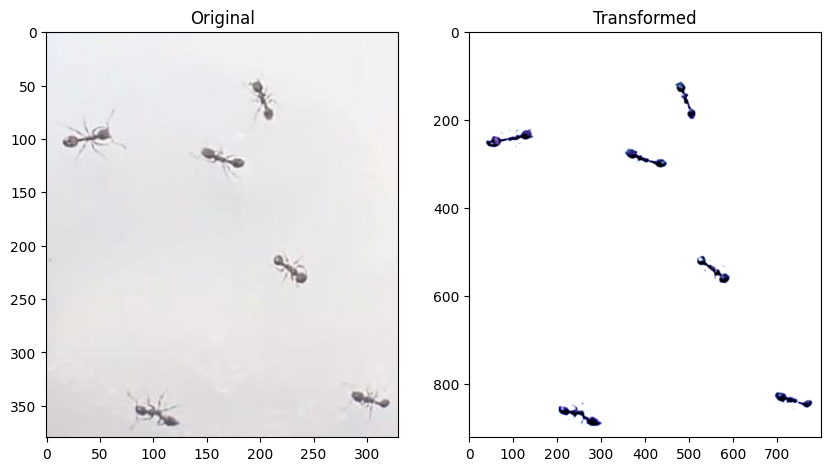

In [133]:
img = Image.open(os.path.join(DIR_DATA, "frame2.jpg"))
# img_f3 = np.array(img_f3)[350:530, 350:630] # hotdog
img = np.array(img)[100:480, 300:630] # corner ants
img = np.array(img)
img_e = feature_extractor(img, return_tensors="pt")
print(img.size)
plot_transform(img, img_e)

## Inference

In [ ]:
output = model(**img_e)

In [158]:
# # save output tensor
# torch.save(output, os.path.join(DIR_DATA, "output.pt"))
# # load
# output = torch.load(os.path.join(DIR_DATA, "output.pt"))

(100, 251)


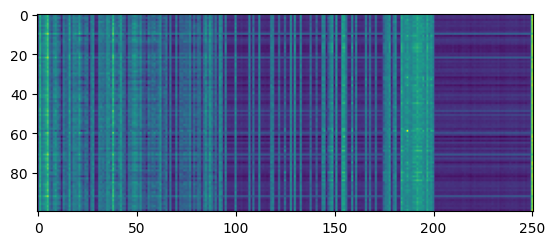

In [160]:
logits = output["logits"][0].detach().numpy()
pred_boxes = output["pred_boxes"][0].detach().numpy()
pred_masks = output["pred_masks"][0].detach().numpy()
print(logits.shape)
plt.imshow(logits)

## Draw attention

Get the prediction matrix

In [145]:
def plot_attn(i, mask, box, ax, is_mask=True):
    if is_mask:
        imgH, imgW = mask[i].shape[:2]
        ax.imshow(mask[i])
    else:
        imgH, imgW = mask.shape[:2]
        ax.imshow(mask)
    # draw the box
    cx = box[i][0]
    cy = box[i][1]
    w = box[i][2]
    h = box[i][3]
    x = cx - w/2
    y = cy - h/2
    ptx = np.array([x, x + w, x + w, x, x]) * imgW
    pty = np.array([y, y, y + h, y + h, y]) * imgH
    area = w * h
    ax.set_title(f"Attention {i}, area: {area:.6f}")
    ax.plot(ptx, pty, color="red", linewidth=2)


(array([77.,  8.,  4.,  2.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  2.]),
 array([6.09975774e-04, 5.05766235e-02, 1.00543268e-01, 1.50509909e-01,
        2.00476557e-01, 2.50443220e-01, 3.00409853e-01, 3.50376487e-01,
        4.00343150e-01, 4.50309783e-01, 5.00276446e-01, 5.50243080e-01,
        6.00209713e-01, 6.50176346e-01, 7.00143039e-01, 7.50109673e-01,
        8.00076306e-01, 8.50042939e-01, 9.00009632e-01, 9.49976265e-01,
        9.99942899e-01]),
 <BarContainer object of 20 artists>)

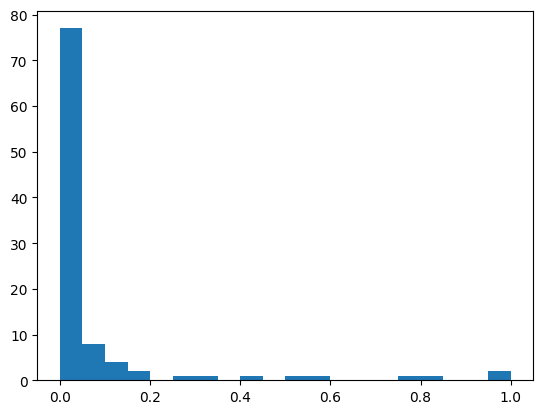

In [161]:
ws = np.array([pred_boxes[i][2] for i in range(100)])
hs = np.array([pred_boxes[i][3] for i in range(100)])
area = ws * hs
plt.hist(area, bins=20)

In [165]:
# idx_sel = np.where((area < 0.2))[0]
idx_sel = [5, 55, 90,
           44, 49, 66,
           22, 54,
           10, 30,
           74, 92,
           37, 71]
print(idx_sel)

[5, 55, 90, 44, 49, 66, 22, 54, 10, 30, 74, 92, 37, 71]


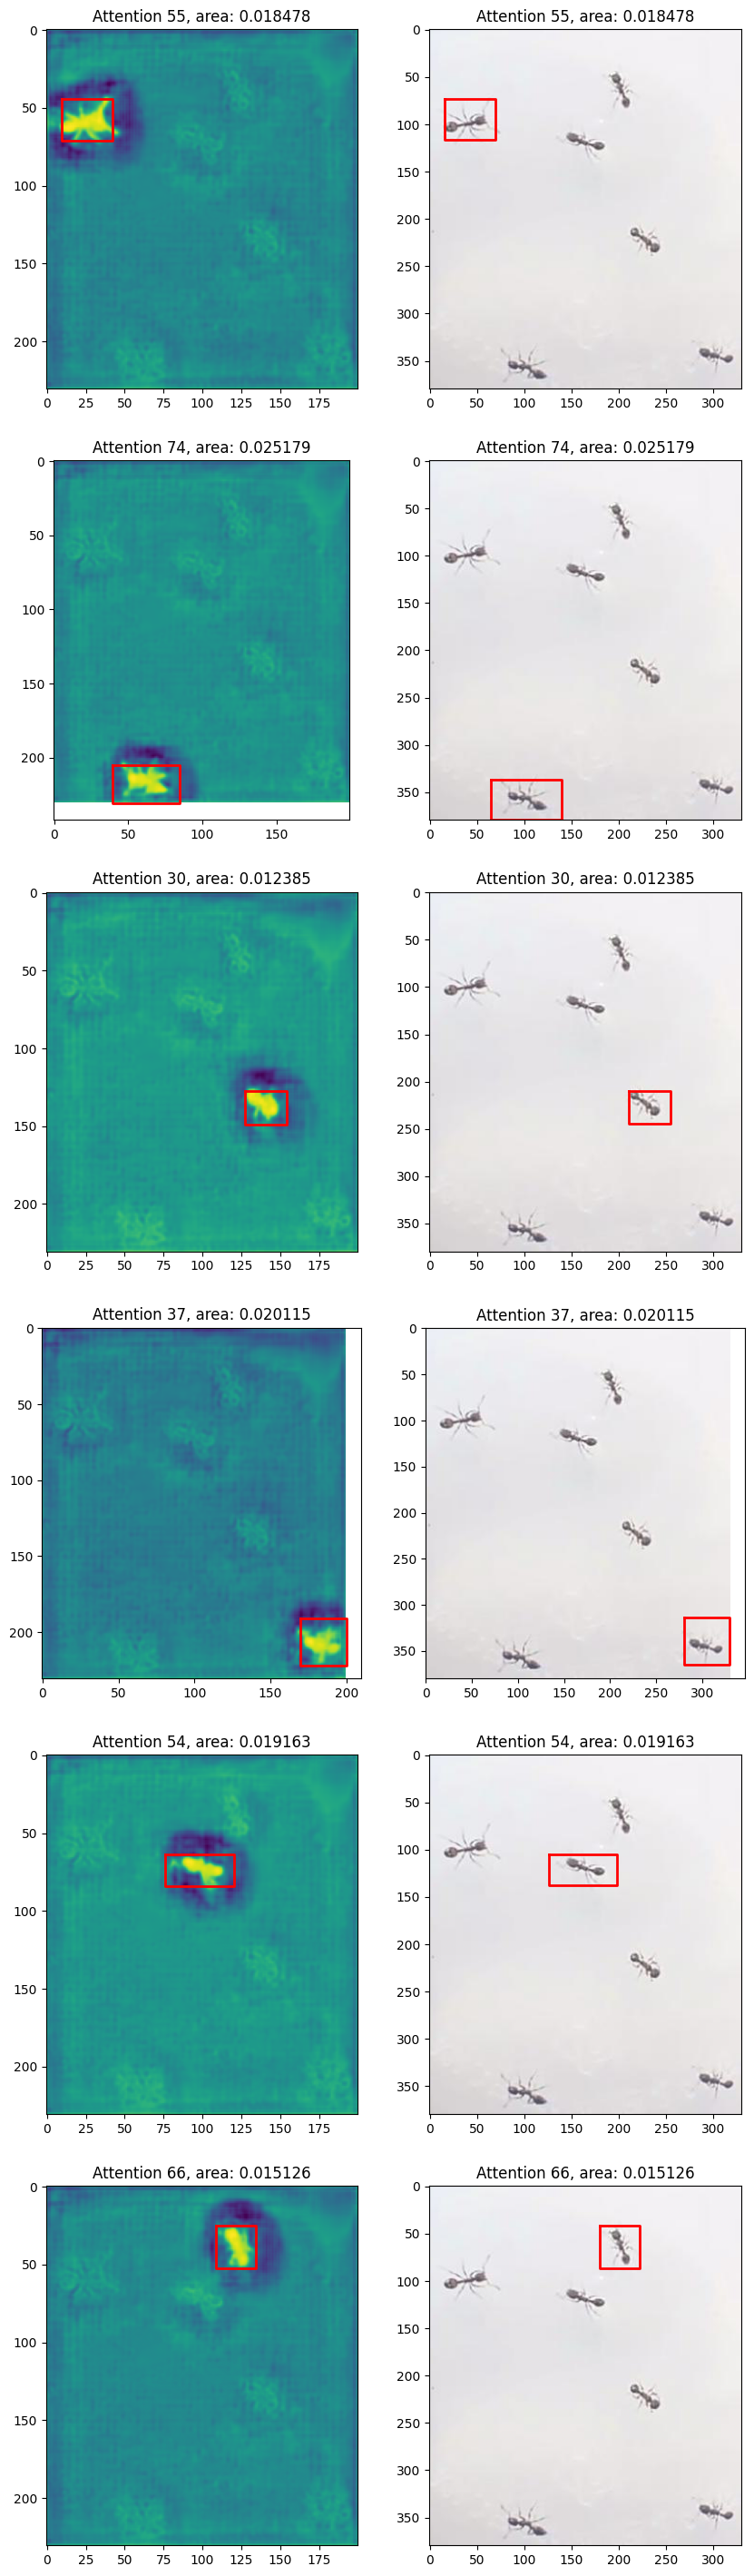

In [251]:
# # randomly select 10 ants
# N_ants = 10
# fig, axs = plt.subplots(N_ants, 2, figsize=(10, 60))
# for i in range(N_ants):
#         # randomly select an index from idx_sel
#         idx = np.random.choice(idx_sel)
#         plot_attn(idx, pred_masks, pred_boxes, axs[i, 0])
#         plot_attn(idx, img, pred_boxes, axs[i, 1], is_mask=False)

# provided list
idx_sel = [55, 74, 30, 37, 54, 66]
species = ["A", "A", "B", "B", "B", "B"]
s2c = {"A": "red", "B": "blue"}

N_ants = len(idx_sel)

plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(N_ants, 2, figsize=(10, 6 * N_ants))
for i in range(N_ants):
    idx = idx_sel[i]
    plot_attn(idx, pred_masks, pred_boxes, axs[i, 0])
    plot_attn(idx, img, pred_boxes, axs[i, 1], is_mask=False)

## Embedding vectors

In [252]:
# PCA on the embeddings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# get the embeddings
embeddings = logits[idx_sel]
# scale the embeddings
embeddings = StandardScaler().fit_transform(embeddings)

# PCA
pca = PCA(n_components=2)
PCs = pca.fit_transform(embeddings)
# variance
var_x = pca.explained_variance_ratio_[0]
var_y = pca.explained_variance_ratio_[1]

df_pc = pd.DataFrame(data=PCs, columns=["PC1", "PC2"])
df_pc["species"] = species
df_pc["idx"] = idx_sel
df_pc["color"] = df_pc["species"].apply(lambda x: s2c[x])
# apply kernel transformation to PCs more separable
df_pc["PC1_k"] = df_pc["PC1"].apply(lambda x: x**2)
df_pc["PC2_k"] = df_pc["PC2"].apply(lambda x: x**2)
df_pc

,PC1,PC2,species,idx,color,PC1_k,PC2_k
0,15.405484,-8.373738,A,55,red,237.328943,70.119493
1,11.523083,12.678517,A,74,red,132.781436,160.744802
2,-7.544106,-1.930417,B,30,blue,56.913543,3.726510
3,-13.574495,5.571950,B,37,blue,184.266923,31.046626
4,1.697026,-1.702943,B,54,blue,2.879896,2.900014
5,-7.506992,-6.243373,B,66,blue,56.354934,38.979711


Visualization

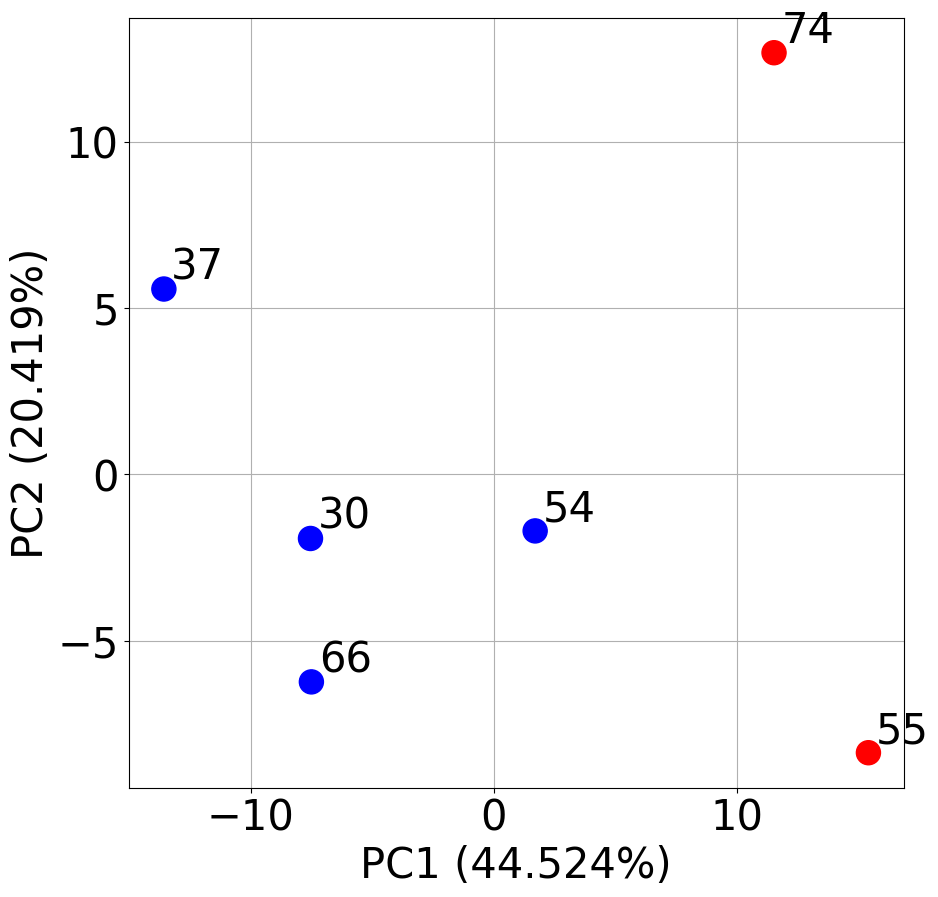

In [253]:
# plot (color by species)
text_jitter = .3
plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df_pc["PC1"], df_pc["PC2"], c=df_pc["color"], s=300)
for i, txt in enumerate(df_pc["idx"]):
    ax.annotate(txt, (df_pc["PC1"][i] + text_jitter, df_pc["PC2"][i] + text_jitter))

ax.set_xlabel(f"PC1 ({var_x * 100:.3f}%)")
ax.set_ylabel(f"PC2 ({var_y * 100:.3f}%)")
# add grid
ax.grid()
